# Wilson Loop

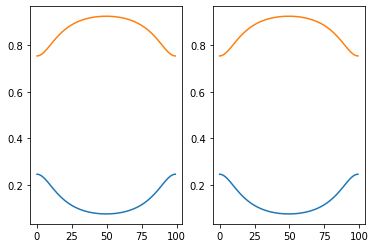

In [121]:
import numpy as np
import matplotlib.pyplot as plt
def Pauli():
    s0 = np.array([[1,0],[0,1]])
    sx = np.array([[0,1],[1,0]])
    sy = np.array([[0,-1j],[1j,0]])
    sz = np.array([[1,0],[0,-1]])
    return s0,sx,sy,sz
#--------------------------------------------------------------
def hamset(kx,ky):
    s0 = np.zeros([2,2],np.complex)
    sx = np.zeros([2,2],np.complex)
    sy = np.zeros([2,2],np.complex)
    sz = np.zeros([2,2],np.complex)
    ham = np.zeros([4,4],np.complex)
    gamx = 0.5
    gamy = 0.5
    lamx = 1.0
    lamy = 1.0
    s0,sx,sy,sz = Pauli()
    ham = (gamx + lamx*np.cos(kx))*np.kron(sx,s0) + lamx*np.sin(kx)*np.kron(-sy,sz) + (gamy + lamy*np.cos(ky))*np.kron(-sy,sy) + lamy*np.sin(ky)*np.kron(-sy,sx)
    return ham    
#--------------------------------------------------------------
def WilsonLoop():
    nkx = 100
    nky = 100
    kxlist = np.linspace(-np.pi, np.pi, nkx)
    kylist = np.linspace(-np.pi, np.pi, nky)
    anglist = []
    for ky in kylist:
        wave1 = []
        wave2 = []
        for kx in kxlist:
            eigval, eigvec = np.linalg.eigh(hamset(kx, ky))
            if kx != np.pi:
                wave1.append(eigvec[:, 0]) # 第一个占据态波函数
                wave2.append(eigvec[:, 1]) # 第二个占据态波函数
            else:
                # 首位波函数相同,消除规范
                wave1.append(wave1[0])
                wave2.append(wave2[0])
        Wan = np.eye(2,dtype=complex)
        for i0 in range(nkx - 1):
            F = np.zeros((2, 2), dtype = complex)
            F[0, 0] = np.dot(wave1[i0 + 1].transpose().conj(), wave1[i0]) # 两个占据态波函数之间的交叠
            F[1, 1] = np.dot(wave2[i0 + 1].transpose().conj(), wave2[i0])
            F[0, 1] = np.dot(wave1[i0 + 1].transpose().conj(), wave2[i0])
            F[1, 0] = np.dot(wave2[i0 + 1].transpose().conj(), wave1[i0])
            Wan = np.dot(F, Wan) 
        eigval, eigvec = np.linalg.eig(Wan)
        ang = np.log(eigval)/2/np.pi/1j 
        for i0 in range(2):
            if np.real(ang[i0]) < 0:
                ang[i0] += 1
        ang = np.sort(ang)
        anglist.append(ang.real)
    return anglist
#------------------------------------------------
def WilsonLoop2():
    nkx = 100
    nky = 100
    kxlist = np.linspace(-np.pi, np.pi, nkx)
    kylist = np.linspace(-np.pi, np.pi, nky)
    hn = hamset(0,0).shape[0]
    Nocc = int(hn/2)
    wave = np.zeros([hn,hn,nkx],np.complex)
    anglist = []
    for ky in kylist:
        ix = 0
        for kx in kxlist: # 计算沿着kx方向的Wilson loop
            eigval, eigvec = np.linalg.eigh(hamset(kx, ky)) # 求解哈密顿量的本征矢量
            if kx != np.pi:
                wave[:,:,ix] = eigvec[:,:] # 存储所有的本征波函数,用来后面计算Wilson loop
                ix += 1
            else:
                # 首尾波函数相同,消除规范
                wave[:,:,nkx - 1] = wave[:,:,0] 
        Wan = np.eye(Nocc,dtype = complex)
        F = np.zeros((Nocc, Nocc), dtype = complex) # Wannier Hamiltonian
        for i0 in range(nkx - 1):
            for i1 in range(Nocc): # 直接通过循环,只遍历占据态的波函数
                for i2 in range(Nocc):
                    F[i1,i2] = np.dot(wave[:,i1,i0 + 1].transpose().conj(),wave[:,i2,i0])
            Wan = np.dot(F, Wan) 
        eigval, eigvec = np.linalg.eig(Wan)
        ang = np.log(eigval)/(2*np.pi*1j) 
        for i0 in range(2):
            if np.real(ang[i0]) < 0:
                ang[i0] += 1
        ang = np.sort(ang)
        anglist.append(ang.real)
    return anglist
#------------------------------------------------------
def main():
    a1 = WilsonLoop()
    a2 = WilsonLoop2()
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    ax1.plot(a1)
    ax2.plot(a2)
#--------------------------------------------------------
if __name__ == '__main__':
    main()
    
    
    
    
    

# Edge State

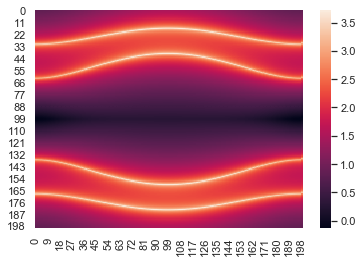

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import seaborn as sns
def Pauli():
    s0 = np.array([[1,0],[0,1]])
    sx = np.array([[0,1],[1,0]])
    sy = np.array([[0,-1j],[1j,0]])
    sz = np.array([[1,0],[0,-1]])
    return s0,sx,sy,sz
#------------------------------------------------
def hamset(ki):
    s0 = np.zeros([2,2],np.complex)
    sx = np.zeros([2,2],np.complex)
    sy = np.zeros([2,2],np.complex)
    sz = np.zeros([2,2],np.complex)
    H00 = np.zeros([4,4],np.complex)
    H01 = np.zeros([4,4],np.complex)
    gamx = 0.5
    gamy = 0.5
    lamx = 1.0
    lamy = 1.0
    s0,sx,sy,sz = Pauli()
    H00 = (gamx + lamx*np.cos(ki))*np.kron(sx,s0) + lamx*np.sin(ki)*np.kron(-sy,sz)
    H01 = (gamy + lamy/2.0)*np.kron(-sy,sy) + lamy/(2*1j)*np.kron(-sy,sx)
    return H00,H01
# -----------------------------------------------------------------------
def Iteration(omega,ki):
    err = 1e-16
    eta = 0.01
    iternum = 200
#     H00 = np.zeros((2,2),np.complex128)
#     H01 = np.zeros((2,2),np.complex128)
    H00,H01 = hamset(ki)
    epsiloni = H00
    epsilons = H00
    epsilons_t = H00
    alphai = H01
    betai = H01.T.conjugate()
    omegac = omega + eta*1j
#     s0,sx,sy,sz = Pauli()
    s0 = np.eye(4)
    for iter in range(iternum):
        g0dem = omegac*s0 - epsiloni
        g0 = np.linalg.inv(g0dem)
        
        mat1 = np.dot(alphai,g0)
        
        mat2 = np.dot(betai,g0)

        g0 = np.dot(mat1,betai)
        
        epsiloni = epsiloni + g0

        epsilons = epsilons + g0

        g0 = np.dot(mat2,alphai)

        epsiloni = epsiloni + g0

        epsilons_t = epsilons_t + g0

        g0 = np.dot(mat1, alphai)
        
        alphai = g0

        g0 = np.dot(mat2,betai)

        betai = g0
          
        real_temp = np.sum(np.concatenate(np.abs(alphai)))
        
        if (real_temp < err):
            break
        
    GLLdem = np.dot(omegac,s0) - epsilons
    GLL = np.linalg.inv(GLLdem)
    #  GLL = epsilons
    GLL =  np.sum(np.concatenate(np.abs(GLL)))


    GRRdem = np.dot(omegac,s0) - epsilons_t
    GRR = np.linalg.inv(GRRdem)
    GRR =  np.sum(np.concatenate(np.abs(GRR)))
    #  GRR = epsilons_t

    GBdem = np.dot(omegac,s0) - epsiloni
    GB = np.linalg.inv(GBdem)
    GB =  np.sum(np.concatenate(np.abs(GB)))
    #  GB = epsiloni
    
    return GLL,GRR,GB
#------------------------------------------------------------
def surface():
    nx = 100
    max_omg = 3
    re = np.zeros((len(range(-nx,nx))**2,5))
    con = 0
    ix = -1
    iy = -1
    GLL = np.zeros((len(range(-nx,nx)),len(range(-nx,nx))))
    GRR = np.zeros((len(range(-nx,nx)),len(range(-nx,nx))))
    GB = np.zeros((len(range(-nx,nx)),len(range(-nx,nx))))
    for i0 in range(-nx,nx):
        kx = np.pi*i0/nx
        for i1 in range(-nx,nx):
            omg = max_omg*i1/nx
            re1,re2,re3 = Iteration(omg,kx)
            re[con,0] = kx
            re[con,1] = omg
            re[con,2] = re1
            re[con,3] = re2
            re[con,4] = re3
            
            GLL[iy,ix] = np.log(re1)
            GRR[iy,ix] = np.log(re2)
            GB[iy,ix] = np.log(re3)
            con += 1
            iy += 1
        ix += 1
        iy = 0
#     np.savetxt("GLL.dat", [kilist,re1list], fmt="%15.10f")
#     np.savetxt("GRR.dat", [kilist,re1list], fmt="%15.10f")
#     np.savetxt("GB.dat", [kilist,re1list], fmt="%15.10f")
    np.savetxt("density.dat",re , fmt="%15.10f")
    return GLL,GRR,GB
#-----------------------------------------------------------------------
def main():
    os.chdir(os.getcwd())
    tstart = time.time()
    GLL,GRR,GB = surface()
    tend = time.time()
    #print(tend - tstart)
    # 绘图
    sns.set()
    ax = sns.heatmap(GB)
    plt.show()
#-----------------------------------------------------------------------
if __name__ == '__main__':
    main()

# Nested Wilson Loop

Consted time is 84.80747


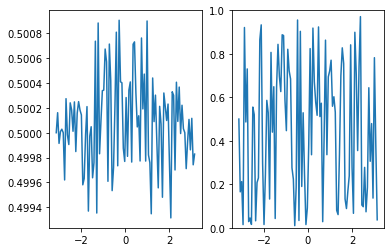

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
#--------------------------------------------------
def hamset(kx,ky):
    # 构建模型哈密顿量
    gamx = 0.5  # hopping inside one unit cell
    lamx = 1   # hopping between unit cells
    gamy = gamx
    lamy = lamx
    xsyb1 = 0.000000000000    # default (not breaking): zero
    xsyb2 = 1.0000000000001   # default (not breaking): unity
    ysyb1 = 0.000000000000    # default (not breaking): zero
    ysyb2 = 1.000000000000    # default (not breaking): unity
    ham = np.zeros((4, 4), dtype = complex)
    ham[0, 0] = xsyb1
    ham[1, 1] = ysyb1
    ham[2, 2] = ysyb1
    ham[3, 3] = xsyb1
    ham[0, 2] = (gamx + lamx * np.exp(1j * kx)) * ysyb2
    ham[1, 3] = gamx + lamx * np.exp(-1j * kx)
    ham[0, 3] = gamy + lamy * np.exp(1j * ky)
    ham[1, 2] = (-gamy - lamy * np.exp(-1j * ky)) * xsyb2
    ham[2, 0] = np.conj(ham[0, 2])
    ham[3, 1] = np.conj(ham[1, 3])
    ham[3, 0] = np.conj(ham[0, 3])
    ham[2, 1] = np.conj(ham[1, 2]) 
    return ham
#-------------------------------------------------------------
def Wilson_kx(kx):
    # 在给定kx的情况下，计算沿着ky方向上的Wilson loop
    # 相当于是讲原本计算Wilson loop的方法，现在拆解成每个离散的点
    nky = 100
    hn = hamset(0,0).shape[0] # 获取哈密顿量的维度，方便构建占据态
    Nocc = int(hn/2)
    wave = np.zeros((hn,hn,nky),dtype = complex) # 存储所有ki点上的本征波函数
    kylist = np.linspace(-np.pi, np.pi, nky)
    # 构建沿着y方向的Wilson loop，此时给定一个kx值进行一次Wilson loop计算
    ix = 0
    for ky in kylist: # 计算沿着kx方向的Wilson loop
        eigval, eigvec = np.linalg.eigh(hamset(kx, ky)) # 求解哈密顿量的本征矢量
        if ky != np.pi:
            wave[:,:,ix] = eigvec[:,:] # 存储所有的本征波函数,用来后面计算Wilson loop
            ix += 1
        else:
            # 首尾波函数相同,消除规范
            wave[:,:,nky - 1] = wave[:,:,0] 
            ix += 1
    # 利用沿着ky方向计算的波函数来构建Wannier hamiltonian
    Wan = np.eye(Nocc,dtype = complex)
    F = np.zeros((Nocc, Nocc), dtype = complex) # Wannier Hamiltonian
    for i0 in range(nky - 1):
        for i1 in range(Nocc): # 直接通过循环,只遍历占据态的波函数，在设定化学势为零的时候，占据态是能带数的一半
            for i2 in range(Nocc): # 不同占据态在相邻kx格点上的波函数交叠
                F[i1,i2] = np.dot(wave[:,i1,i0 + 1].transpose().conj(),wave[:,i2,i0])
        Wan = np.dot(F, Wan) 
    eigval, eigvec = np.linalg.eig(Wan) # 这里Wannier 哈密顿量并不是厄米的，所以求解得到的本征值的顺序并不一定就是按顺序排列的
    mux = np.log(eigval)/(2*np.pi*1j) # 从Wannier哈密顿量中计算Wannier center
    wannier_vec1 = eigvec[:, np.argsort(np.real(mux))[0]] # 按照特定的顺序排列本征矢量
    wannier_vec2 = eigvec[:, np.argsort(np.real(mux))[1]]
    # 返回两个Wannier band在确定kx下的本征矢量，因为对于一个四带模型，这里的占据态的数目是2，所以必然存在两个Wannier band
    return wannier_vec1,wannier_vec2    
#---------------------------------------------------------------------------------------------------------
def Wilson_ky(ky):
    # 在给定kx的情况下，计算沿着ky方向上的Wilson loop
    # 相当于是讲原本计算Wilson loop的方法，现在拆解成每个离散的点
    nkx = 100
    hn = hamset(0,0).shape[0] # 获取哈密顿量的维度，方便构建占据态
    Nocc = int(hn/2)
    wave = np.zeros((hn,hn,nkx),dtype = complex) # 存储所有ki点上的本征波函数
    kxlist = np.linspace(-np.pi, np.pi, nkx)
    # 构建沿着y方向的Wilson loop，此时给定一个kx值进行一次Wilson loop计算
    ix = 0
    for kx in kxlist: # 计算沿着kx方向的Wilson loop
        eigval, eigvec = np.linalg.eigh(hamset(kx, ky)) # 求解哈密顿量的本征矢量
        if kx != np.pi:
            wave[:,:,ix] = eigvec[:,:] # 存储所有的本征波函数,用来后面计算Wilson loop
            ix += 1
        else:
            # 首尾波函数相同,消除规范
            wave[:,:,nkx - 1] = wave[:,:,0] 
            ix += 1
    # 利用沿着ky方向计算的波函数来构建Wannier hamiltonian
    Wan = np.eye(Nocc,dtype = complex)
    F = np.zeros((Nocc, Nocc), dtype = complex) # Wannier Hamiltonian
    for i0 in range(nkx - 1):
        for i1 in range(Nocc): # 直接通过循环,只遍历占据态的波函数
            for i2 in range(Nocc):
                F[i1,i2] = np.dot(wave[:,i1,i0 + 1].transpose().conj(),wave[:,i2,i0])
        Wan = np.dot(F, Wan) 
    eigval, eigvec = np.linalg.eig(Wan) # 这里Wannier 哈密顿量并不是厄米的，所以求解得到的本征值的顺序并不一定就是按顺序排列的
    mux = np.log(eigval)/(2*np.pi*1j) # 从Wannier哈密顿量中计算Wannier center
    wannier_vec1 = eigvec[:, np.argsort(np.real(mux))[0]] # 按照特定的顺序排列本征矢量(这里的顺序是从小到大排列)
    wannier_vec2 = eigvec[:, np.argsort(np.real(mux))[1]]
    return wannier_vec1,wannier_vec2 # 返回两个Wannier band在确定ky下的本征矢量
#---------------------------------------------------------------------------------------------------------
def Nested_Wilson_loop_kx():
    nkx = 100 # 计算Nested Wilson loop时撒点的数目
    nky = 100
    hn = hamset(0,0).shape[0] # 获取哈密顿量的维度，方便构建占据态
    Nocc = int(hn/2) # 占据态能带数目
    kxlist = np.linspace(-np.pi, np.pi, nkx)
    kylist = np.linspace(-np.pi, np.pi, nky)
    wave = np.zeros((hn,hn,nky),dtype = complex)
    pmulist = []
    for kx in kxlist:
        ix = 0 # 这里的ix用来索引ky，将所有固定kx下面的沿ky方向的波函数都存储起来
        for ky in kylist: # 沿着一个方向遍历动量
            eigval,eigvec = np.linalg.eigh(hamset(kx,ky)) # 求解哈密顿量的本征矢量和本征值
            if ky != np.pi:
                wave[:,:,ix] = eigvec[:,:] # 将沿着ky方向的所有本征波函数存储
                ix += 1
            else:
                wave[:,:,nky - 1] = wave[:,:,0] # 在边界上保证波函数首尾相接
                ix += 1
            #------------------------------------------------------------------
        i0 = 0
        wmu = np.zeros((4,nky),dtype = complex) # 用来构建新的Wannier basis
        for ky in kylist:
            if ky != np.pi:
                wann_v1,wann_v2 = Wilson_ky(ky) # 给定一个ky，沿着kx方向做完Wilson loop，得到两个Wannier band对应的本征矢量
                # 将两个占据态的都进行计算，哈密顿量的每个占据态于Wannier band占据态的每个分量进行相乘然后求和(这里的本征值是按照顺序排列的，所以只使用了占据态)
                wmu[:,i0] = wave[:,0,i0]*wann_v1[0] + wave[:,1,i0]*wann_v1[1] 
            else:
                wmu[:,nky - 1] = wmu[:,0] # 在新的Wannier basis下，波函数首尾相接
            i0 += 1
        #--------------------------------------
        # 对新的Wannier basis构建的函数计算Wilson loop，只不过此时的可能就是一个复数相乘，因为只有一条带，那么自然就不会是个矩阵
        wan = 1
        for i0 in range(nkx - 1):
            F0 = np.dot(wmu[:,i0 + 1].T.conj(),wmu[:,i0])
            wan = F0*wan
        pmu = np.log(wan)/(2*1j*np.pi)
        if np.real(pmu) < 0:
            pmu += 1
        pmulist.append(pmu.real)
    return kxlist,pmulist
#---------------------------------------------------------------------------------------------------------
def Nested_Wilson_loop_ky():
    nkx = 100 # 计算Nested Wilson loop时撒点的数目
    nky = 100
    hn = hamset(0,0).shape[0] # 获取哈密顿量的维度，方便构建占据态
    Nocc = int(hn/2) # 占据态能带数目
    kxlist = np.linspace(-np.pi, np.pi, nkx)
    kylist = np.linspace(-np.pi, np.pi, nky)
    wave = np.zeros((hn,hn,nky),dtype = complex) # 存储哈密顿量对应的本征波函数
    pmulist = []
    for ky in kylist:
        ix = 0 # 这里的ix用来索引ky，将所有固定kx下面的沿ky方向的波函数都存储起来
        for kx in kxlist: # 沿着一个方向遍历动量
            eigval,eigvec = np.linalg.eigh(hamset(kx,ky)) # 求解哈密顿量的本征矢量和本征值
            if kx != np.pi:
                wave[:,:,ix] = eigvec[:,:] # 将沿着ky方向的所有本征值对应的本征波函数存储
                ix += 1
            else:
                wave[:,:,nky - 1] = wave[:,:,0] # 在边界上保证波函数首尾相接
                ix += 1
            #------------------------------------------------------------------
        i0 = 0
        wmu = np.zeros((4,nkx),dtype = complex) # 用来构建新的Wannier basis
        for kx in kylist:
            if kx != np.pi:
                wann_v1,wann_v2 = Wilson_kx(kx) # 给定一个ky，沿着kx方向做完Wilson loop，得到两个Wannier band对应的本征矢量
                # 将两个占据态的都进行计算，哈密顿量的每个占据态于Wannier band占据态的每个分量进行相乘然后求和(这里的本征值是按照顺序排列的，所以只使用了占据态)
                wmu[:,i0] = wave[:,0,i0]*wann_v1[0] + wave[:,1,i0]*wann_v1[1] 
            else:
                wmu[:,nky - 1] = wmu[:,0] # 在新的Wannier basis下，波函数首尾相接
            i0 += 1
        #--------------------------------------
        # 对新的Wannier basis构建的函数计算Wilson loop，只不过此时的可能就是一个复数相乘，因为只有一条带，那么自然就不会是个矩阵
        wan = 1
        for i0 in range(nky - 1):
            F0 = np.dot(wmu[:,i0 + 1].T.conj(),wmu[:,i0])
            wan = F0*wan
        pmu = np.log(wan)/(2*1j*np.pi)
        if np.real(pmu) < 0:
            pmu += 1
        pmulist.append(pmu.real)
    return kylist,pmulist
#-------------------------------------------------------
def main1():
    x1,y1 = Nested_Wilson_loop_kx()
    x2,y2 = Nested_Wilson_loop_ky()
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    ax1.plot(x1,y1)
    ax2.plot(x2,y2)
    plt.ylim([0,1])
#-------------------------------------------------------
def main2():
    x,y = Nested_Wilson_loop_kx()
#     x,y = Nested_Wilson_loop_ky()
    plt.plot(x,y)
    plt.ylim(0,1)
#-------------------------------------------------------
if __name__ == '__main__':
    os.chdir(os.getcwd()) # 更改工作目录到当前文件夹
    tstart = time.time() # 获取系统时间
    main1()
    tend = time.time()
    print("Consted time is %.5f" % (tend - tstart))

                


Consted time is 0.01652


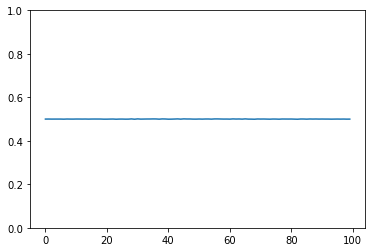

Consted time is 0.01684


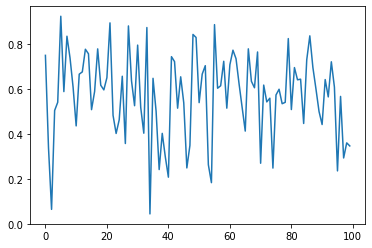

In [9]:
v1[1]

(0.719207104462154+0j)